In [46]:
import yaml
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from types import SimpleNamespace
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import json
from sklearn.cluster import KMeans
import umap.umap_ as umap
import scipy
import rasterio
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering
import matplotlib.lines as mlines
import datetime
from osgeo import gdal, gdalconst
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist
from adjustText import adjust_text
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from adjustText import adjust_text
from scipy.ndimage import binary_erosion
from concurrent.futures import ThreadPoolExecutor
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Wedge
import copy
from matplotlib import font_manager as fm
from torchvision.transforms import ToTensor
import h5py
import feather
import cv2
import glob
import re
import matplotlib.lines as mlines

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 5         # 全域預設的文字大小
mpl.rcParams['axes.labelsize'] = 7    # x, y 軸標籤 (label) 的文字大小
mpl.rcParams['xtick.labelsize'] = 5    # x 軸刻度 (tick) 的文字大小
mpl.rcParams['ytick.labelsize'] = 5   # y 軸刻度 (tick) 的文字大小
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 0.5
mpl.rcParams['legend.frameon'] = False

In [47]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

## 會用到的函數

In [48]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
        
def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance


# 計算兩個經緯度點之間的距離，支持向量化操作
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑，單位：公里
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c
def create_figure_mm(width_mm, height_mm, dpi=100):
    """
    根據毫米為單位的寬度和高度創建圖形
    :param width_mm: 寬度（以毫米為單位）
    :param height_mm: 高度（以毫米為單位）
    :param dpi: 圖形的分辨率（每英寸的點數）
    :return: fig, ax 圖形和軸對象
    """
    width_inch = width_mm / 25.4  # 將寬度從毫米轉換為英寸
    height_inch = height_mm / 25.4  # 將高度從毫米轉換為英寸
    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)
    return fig, ax
def get_significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
def get_chinese_sciname(target_name):
    change_names = {
    'Anas_zonorhyncha': 'Anas_poecilorhyncha', 
    'Cyanoderma_ruficeps': 'Stachyridopsis_ruficeps', 
    'Erythrogenys_erythrocnemis': 'Pomatorhinus_erythrocnemis', 
    'Ictinaetus_malaiensis': 'Ictinaetus_malayensis', 
    'Lewinia_striata': 'Gallirallus_striatus', 
    'Machlolophus_holsti': 'Parus_holsti', 
    'Pterorhinus_poecilorhynchus': 'Garrulax_poecilorhynchus', 
    'Pterorhinus_ruficeps': 'Garrulax_ruficeps', 
    'Schoeniparus_brunneus': 'Alcippe_brunnea', 
    'Sittiparus_castaneoventris': 'Poecile_varius', 
    'Synoicus_chinensis': 'Coturnix_chinensis', 
    'Taenioptynx_brodiei': 'Glaucidium_brodiei', 
    'Tarsiger_formosanus': 'Tarsiger_indicus', 
    'Turdus_niveiceps': 'Turdus_poliocephalus', 
    'Zapornia_fusca': 'Porzana_fusca'
    }
    df_name = pd.read_csv('../2023臺灣鳥類名錄-20230419.csv')
    for (new_name, orig_name) in change_names.items():
        if target_name == orig_name:
            target_name = new_name
            
    df_target = df_name[df_name['學名'] == target_name.replace('_', ' ')]
    return df_target['中文名'].values[0]
    
def mm2inch(*values):
    return [v / 25.4 for v in values]

In [112]:
# create a plot folder of the specific exp_id
plot_path = os.path.join('plots', run_id)
plot_path_FigS1_trainvalidationsplit = os.path.join(plot_path, 'FigS1_trainvalidationsplit')
create_folder(plot_path_FigS1_trainvalidationsplit)
plot_path_df = os.path.join(plot_path, 'Fig4_dataframe')
plot_path_nichespace = os.path.join(plot_path, 'Fig4_niche_space')
plot_path_ecogeo_basedonDeepSDMpred = os.path.join(plot_path, 'Fig6_EcoGeo_comparison_basedonDeepSDMpred')
plot_path_biotop = os.path.join(plot_path, 'Fig6_biotop')
plot_path_subplots = os.path.join(plot_path, 'Fig6_subplots')
plot_path_nichespace_h5 = os.path.join(plot_path_nichespace, 'h5')

In [50]:
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
with open(os.path.join(predicts_path, 'DeepSDM_conf.yaml'), 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))

with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)

with open(os.path.join(predicts_path, 'env_inf.json'), 'r') as f:
    env_inf = json.load(f)
    
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    extent_binary = f.read(1)
# load extent binary map
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    crs = f.crs
    transform = f.transform
    height, width = f.shape
    lon_min, lat_max = rasterio.transform.xy(transform, 0, 0)  # 左上角
    lon_max, lat_min = rasterio.transform.xy(transform, height - 1, width - 1)  # 右下角
    extent_binary = f.read(1)
extent_binary_extent = [lon_min, lon_max, lat_min, lat_max]

In [51]:
deepsdm_h5_path = os.path.join('predicts', run_id, 'h5', '[SPECIES]', '[SPECIES].h5')
maxent_h5_path = os.path.join('predict_maxent', run_id, 'h5', 'all', '[SPECIES]', '[SPECIES].h5')

In [52]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])
date_list_train = DeepSDM_conf.training_conf['date_list_train']
date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
env_list = DeepSDM_conf.training_conf['env_list']

In [53]:
with open(os.path.join(plot_path_df, 'extent_info.yaml'), 'rb') as f:
    extent_info = yaml.load(f, yaml.FullLoader)
df_grid = feather.read_dataframe(os.path.join(plot_path_df, 'df_grid.feather'))
df_env_value = feather.read_dataframe(os.path.join(plot_path_df, 'env_value.feather'))
df_spearman_pre = pd.read_csv(os.path.join(plot_path_nichespace, 'spearman_info_basedonDeepSDMpred.csv'))

# table

In [5]:
# 1. 讀取遮罩檔 (extent_binary.tif)
extent_path = './workspace/extent_binary.tif'
with rasterio.open(extent_path, 'r') as f:
    extent_binary = f.read(1)

destination = gdal.Open(extent_path)
dst_transform = destination.GetGeoTransform()
dst_projection = destination.GetProjection()
dst_xsize = destination.RasterXSize
dst_ysize = destination.RasterYSize

# 2. 找出 /work/klok0126/landcover 資料夾中的所有 nc 檔案
nc_folder = '/work/klok0126/landcover'
nc_files = glob.glob(os.path.join(nc_folder, '*.nc'))

results = []  # 用來存放每個檔案的統計結果

# 3. 處理每個 nc 檔案
for nc_file in nc_files:
    # 建立 GDAL 讀取子資料集的字串，此處讀取 "lccs_class" 層
    dataset_path = f'NETCDF:{nc_file}:lccs_class'
    src_nc = gdal.Open(dataset_path, gdalconst.GA_ReadOnly)
    if src_nc is None:
        print(f"無法開啟檔案 {nc_file}")
        continue
    src_proj = src_nc.GetProjection()

    # 建立臨時輸出檔 (可用 /tmp/temp.tif 或使用 vsimem)
    temp_tif = '/tmp/temp.tif'
    dst_driver = gdal.GetDriverByName('GTiff')
    dst_tif = dst_driver.Create(temp_tif, dst_xsize, dst_ysize, 1, gdalconst.GDT_Int32)
    dst_tif.SetGeoTransform(dst_transform)
    dst_tif.SetProjection(dst_projection)

    # 重投影：從 src_nc 重投影到 dst_tif
    gdal.ReprojectImage(src_nc, dst_tif, src_proj, dst_projection, gdalconst.GRA_Mode)


    # 讀取重投影後的陣列
    reprojected = dst_tif.GetRasterBand(1).ReadAsArray()

    # 根據 extent_binary 做遮罩：extent_binary==0 的位置設為 nan，其餘保留重投影後的值
    # （假設 extent_binary 為 0 表示無效區域）
    landcovervalue = np.where(extent_binary == 0, np.nan, reprojected)

    # 統計各 landcover 類別的像元數量（忽略 nan）
    unique_vals, counts = np.unique(landcovervalue[~np.isnan(landcovervalue)], return_counts=True)
    # 將 unique 值轉為 int，並組成字典
    count_dict = {int(val): int(cnt) for val, cnt in zip(unique_vals, counts)}

    # 將結果儲存，並記錄來源檔名
    results.append({
        'filename': os.path.basename(nc_file),
        'counts': count_dict
    })

    # 清理釋放資源
    dst_tif = None
    dst_driver = None
    src_nc = None
    # 移除臨時檔案
    if os.path.exists(temp_tif):
        os.remove(temp_tif)

# 4. 將所有檔案的統計結果存成 JSON 檔案
output_json = 'landcover_counts.json'
# with open(output_json, 'w') as f:
#     json.dump(results, f, indent=2)

print("統計結果已存到", output_json)


統計結果已存到 landcover_counts.json


In [42]:
total_counts = {}

for item in results:
    # 從檔名中抓取年份
    match = re.search(r'P1Y-(\d{4})', item['filename'])
    if match:
        year = int(match.group(1))
        # 只處理 2009 至 2018 年的數據
        if 2009 <= year <= 2018:
            for key, count in item['counts'].items():
                total_counts[key] = total_counts.get(key, 0) + count

print(total_counts)

print({key:(total_counts[key]/sum(list(total_counts.values()))) for key in total_counts})

{10: 77674, 11: 46151, 12: 677, 20: 65780, 30: 32901, 40: 12682, 50: 506418, 70: 540, 80: 66, 100: 28, 120: 62, 130: 90, 150: 505, 160: 999, 170: 2835, 180: 6759, 190: 38147, 210: 4498, 110: 8}
{10: 0.09747998293215532, 11: 0.05791897793730077, 12: 0.0008496272683918576, 20: 0.08255314876634623, 30: 0.041290379257548755, 40: 0.015915765166536984, 50: 0.6355488065058608, 70: 0.0006776938329861198, 80: 8.282924625385909e-05, 100: 3.513968022890992e-05, 120: 7.780929193544339e-05, 130: 0.00011294897216435331, 150: 0.0006337692326999824, 160: 0.0012537335910243216, 170: 0.0035578926231771293, 180: 0.008482467809542933, 190: 0.04787404934615095, 210: 0.005644938631058458, 110: 1.0039908636831405e-05}


In [ ]:
{10: 0.09747998293215532, 
 11: 0.05791897793730077, 
 12: 0.0008496272683918576, 
 20: 0.08255314876634623, 
 30: 0.041290379257548755, 
 40: 0.015915765166536984, 
 50: 0.6355488065058608, 
 70: 0.0006776938329861198, 
 80: 8.282924625385909e-05, 
 100: 3.513968022890992e-05, 
 120: 7.780929193544339e-05, 
 130: 0.00011294897216435331, 
 150: 0.0006337692326999824, 
 160: 0.0012537335910243216, 
 170: 0.0035578926231771293, 
 180: 0.008482467809542933, 
 190: 0.04787404934615095, 
 210: 0.005644938631058458, 
 110: 1.0039908636831405e-05}

# Figure

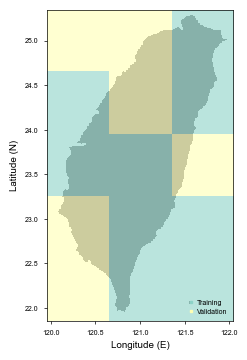

In [114]:
partition_file='./workspace/partition.txt'
spatial_conf = SimpleNamespace(**DeepSDM_conf.spatial_conf_tmp)
train_val_partitions = np.loadtxt(partition_file, delimiter=',')
train_val_mask = cv2.resize(train_val_partitions, (spatial_conf.num_of_grid_x * spatial_conf.grid_size, spatial_conf.num_of_grid_y * spatial_conf.grid_size), interpolation=cv2.INTER_NEAREST)


fig, ax = plt.subplots(figsize = mm2inch(40, 100), constrained_layout = True)
ax.imshow(np.where(extent_binary == 0, np.nan, extent_binary), extent = extent_binary_extent, cmap = ListedColormap('grey'))
ax.imshow(train_val_mask, alpha = 0.6, cmap = ListedColormap(['#ffffb3', '#8dd3c7']), extent = extent_binary_extent)
ax.set_xlabel('Longitude (E)')
ax.set_ylabel('Latitude (N)')

# 建立代理對象
validation_proxy = mlines.Line2D([], [], color='#ffffb3', marker='s', linestyle='None', markersize=2, label='Validation')
training_proxy = mlines.Line2D([], [], color='#8dd3c7', marker='s', linestyle='None', markersize=2, label='Training')

ax.legend(handles=[training_proxy, validation_proxy], loc='lower right', handletextpad=-0.2)
plt.savefig(os.path.join(plot_path_FigS1_trainvalidationsplit, 'train_validation_split.pdf'), dpi = 500, transparent = True)
plt.show()

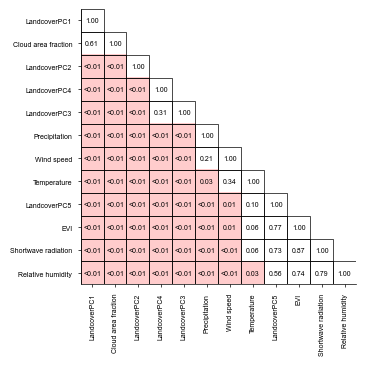

In [109]:
# 設置 Species 為索引
df_attention_order = df_attention.copy()
df_attention_order.set_index('Species', inplace=True)

# 確保 "landcover_PC00" 存在於 DataFrame
if "landcover_PC00" not in df_attention_order.columns:
    raise ValueError("Column 'landcover_PC00' not found in df_attention.")

# 依據 "landcover_PC00" 由小到大排序物種
df_attention_order = df_attention_order.sort_values(by="landcover_PC00", ascending=True)

# 計算每個環境因子的平均 Attention Score，並排序（由大到小）
factor_order = df_attention_order.mean().sort_values(ascending=False).index

# 重新排序 DataFrame 的列（環境因子）
df_attention_order = df_attention_order[factor_order]

df_attention_order.index = [f"{sp.split('_')[0]} {sp.split('_')[1]}" for sp in list(df_attention_order.index)]
df_attention_order.columns = [env_list_change[env] for env in df_attention_order.columns]
# 取得排序後的環境因子名稱
sorted_env_factors = df_attention_order.columns

# 重新計算 p-value 矩陣（依照新的順序）
p_value_matrix_sorted = pd.DataFrame(np.ones((len(sorted_env_factors), len(sorted_env_factors))), 
                                     index=sorted_env_factors, columns=sorted_env_factors)

for i, factor1 in enumerate(sorted_env_factors):
    for j, factor2 in enumerate(sorted_env_factors):
        # 設置對角線值為 1
        if i == j:
            p_value_matrix_sorted.loc[factor1, factor2] = 1.0
        else:
            _, p_value = stats.mannwhitneyu(df_attention_order[factor1], df_attention_order[factor2], alternative='two-sided')
            p_value_matrix_sorted.loc[factor1, factor2] = p_value
            p_value_matrix_sorted.loc[factor2, factor1] = p_value  # 對稱填充

# 轉換 p-value 矩陣為 NumPy 陣列
p_value_array = p_value_matrix_sorted.to_numpy()


threshold = 0.05
custom_cmap = ListedColormap(["red", "white"])

# 創建布林遮罩：小於 0.05（紅色），大於等於 0.05（白色）
color_mask = np.where(p_value_array < threshold, 0, 1)  # 0: 紅色, 1: 白色

# 創建右上三角形 mask（包含對角線），用 NaN 隱藏
upper_triangle_mask = np.triu(np.ones_like(p_value_array, dtype=bool), k=1)
color_mask = np.where(upper_triangle_mask, np.nan, color_mask)

# 繪製 p-value 矩陣（使用 ax.imshow）
fig, ax = plt.subplots(figsize=mm2inch(90, 90), constrained_layout = True)

# 顯示矩陣，應用自定義 colormap
ax.imshow(color_mask, cmap=custom_cmap, interpolation='nearest', alpha=0.2)

# 設置坐標標籤
ax.set_xticks(np.arange(len(sorted_env_factors)))
ax.set_yticks(np.arange(len(sorted_env_factors)))
ax.set_xticklabels(sorted_env_factors, rotation=90)
ax.set_yticklabels(sorted_env_factors)

# 手動繪製左下三角形（包含對角線）的框線
for i in range(len(sorted_env_factors)):
    for j in range(len(sorted_env_factors)):
        if i >= j:  # 只繪製左下三角的框線
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

# 在矩陣中標記 p-value（僅左下三角，右上三角留空白）
for i in range(len(sorted_env_factors)):
    for j in range(len(sorted_env_factors)):
        if i >= j:  # 只顯示左下三角和對角線部分
            p_val = p_value_matrix_sorted.iloc[i, j]
            if round(p_val, 2) < 0.01:
                text = "<0.01"
            else:
                text = f"{round(p_val, 2):.2f}"  # 四捨五入到 0.01
            ax.text(j, i, text, ha='center', va='center', color='black', fontsize=5,)

# 隱藏上方與右方的邊線
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(plot_path_attentionstats, 'median.pdf'), transparent = True, dpi = 500)
# 顯示圖表
plt.show()


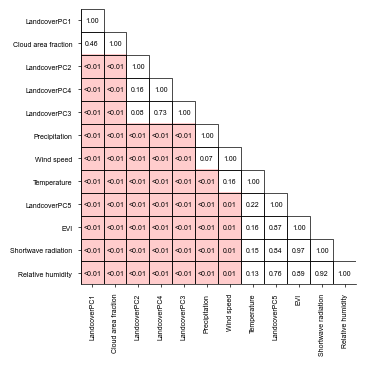

In [110]:
from scipy.stats import levene

# 重新計算 p-value 矩陣（使用 Levene's Test）
p_value_matrix_sorted = pd.DataFrame(np.ones((len(sorted_env_factors), len(sorted_env_factors))), 
                                     index=sorted_env_factors, columns=sorted_env_factors)

for i, factor1 in enumerate(sorted_env_factors):
    for j, factor2 in enumerate(sorted_env_factors):
        # 設置對角線值為 1
        if i == j:
            p_value_matrix_sorted.loc[factor1, factor2] = 1.0
        else:
            _, p_value = levene(df_attention_order[factor1], df_attention_order[factor2])
            p_value_matrix_sorted.loc[factor1, factor2] = p_value
            p_value_matrix_sorted.loc[factor2, factor1] = p_value  # 對稱填充

# 轉換 p-value 矩陣為 NumPy 陣列
p_value_array = p_value_matrix_sorted.to_numpy()

threshold = 0.05
custom_cmap = ListedColormap(["red", "white"])

# 創建布林遮罩：小於 0.05（紅色），大於等於 0.05（白色）
color_mask = np.where(p_value_array < threshold, 0, 1)  # 0: 紅色, 1: 白色

# 創建右上三角形 mask（包含對角線），用 NaN 隱藏
upper_triangle_mask = np.triu(np.ones_like(p_value_array, dtype=bool), k=1)
color_mask = np.where(upper_triangle_mask, np.nan, color_mask)

# 繪製 p-value 矩陣（使用 ax.imshow）
fig, ax = plt.subplots(figsize=mm2inch(90, 90), constrained_layout=True)

# 顯示矩陣，應用自定義 colormap
ax.imshow(color_mask, cmap=custom_cmap, interpolation='nearest', alpha=0.2)

# 設置坐標標籤
ax.set_xticks(np.arange(len(sorted_env_factors)))
ax.set_yticks(np.arange(len(sorted_env_factors)))
ax.set_xticklabels(sorted_env_factors, rotation=90)
ax.set_yticklabels(sorted_env_factors)

# 手動繪製左下三角形（包含對角線）的框線
for i in range(len(sorted_env_factors)):
    for j in range(len(sorted_env_factors)):
        if i >= j:  # 只繪製左下三角的框線
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

# 在矩陣中標記 p-value（僅左下三角，右上三角留空白）
for i in range(len(sorted_env_factors)):
    for j in range(len(sorted_env_factors)):
        if i >= j:  # 只顯示左下三角和對角線部分
            p_val = p_value_matrix_sorted.iloc[i, j]
            if round(p_val, 2) < 0.01:
                text = "<0.01"
            else:
                text = f"{round(p_val, 2):.2f}"  # 四捨五入到 0.01
            ax.text(j, i, text, ha='center', va='center', color='black', fontsize=5,)

# 隱藏上方與右方的邊線
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(plot_path_attentionstats, 'variance_test.pdf'), transparent=True, dpi=500)

# 顯示圖表
plt.show()


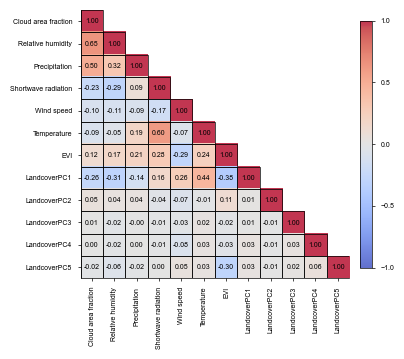

In [64]:
import numpy.ma as ma

# 轉換數據為 NumPy 矩陣
correlation_array = df_env_corr.to_numpy()
sorted_env_factors = df_env_corr.columns

# 建立遮罩：右上三角 (不含對角線) 為 True
mask = np.triu(np.ones_like(correlation_array, dtype=bool), k=1)
# 將 correlation_array 轉為 masked array，遮罩右上三角
masked_corr = ma.array(correlation_array, mask=mask)

# 複製 colormap 並設定遮罩區域為白色
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='white')

# 創建圖表，使用 constrained_layout=True 以符合 B 的版面配置
fig, ax = plt.subplots(figsize=mm2inch(100, 100), constrained_layout=True)

# 顯示矩陣，使用 masked array 與自訂 colormap
cax = ax.imshow(masked_corr, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1, alpha = 0.8)

# 加入 colorbar 作為 legend，調整 fraction 與 pad 參數以取得適合的尺寸
cb = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cb.ax.tick_params()  # 可調整 colorbar 的字體大小
cb.ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
# 設置坐標標籤
ax.set_xticks(np.arange(len(sorted_env_factors)))
ax.set_yticks(np.arange(len(sorted_env_factors)))
ax.set_xticklabels([env_list_change[i] for i in sorted_env_factors], rotation=90)
ax.set_yticklabels([env_list_change[i] for i in sorted_env_factors])

# 僅在左下三角（包含對角線）中標記數值並繪製框線
for i in range(len(sorted_env_factors)):
    for j in range(len(sorted_env_factors)):
        if i >= j:  # 僅針對左下三角和對角線部分
            # 繪製格線框線
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                 fill=False, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)
            # 在框內標記數值，保留兩位小數
            value = correlation_array[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center',
                    color='black', fontsize=5)

# 隱藏上、右邊框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(plot_path_envcorrelation, 'env_correlation.pdf'),
            dpi=500, transparent=True)
plt.show()


In [ ]:
nichespace_deepsdm_all, nichespace_deepsdm_all_nonflatten = PU.get_deepsdm_nichespace(suffix = 'max')

Evaluating 20 clusters...

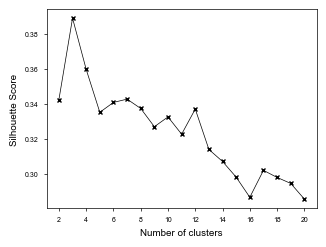

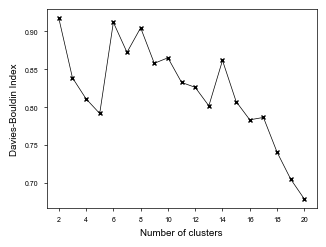

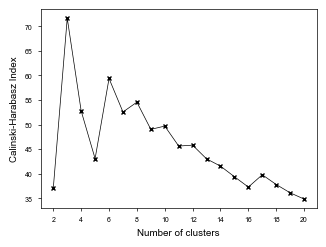

In [99]:
# Step 1: 測試最適合的分群數
# Define the range of clusters to evaluate
K = range(2, 21)

# Initialize lists to store the scores for each number of clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Evaluate clustering for each number of clusters using AgglomerativeClustering (階層式聚類)
for k in K:
    print(f"\rEvaluating {k} clusters...", end = '')
    
    # 使用 AgglomerativeClustering 進行階層式聚類並分配標籤
    clustering = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='average')
    labels = clustering.fit_predict(nichespace_deepsdm_all)
    
    # Calculate Silhouette Score
    silhouette_scores.append(silhouette_score(nichespace_deepsdm_all, labels))
    
    # Calculate Davies-Bouldin Index
    davies_bouldin_scores.append(davies_bouldin_score(nichespace_deepsdm_all, labels))
    
    # Calculate Calinski-Harabasz Index
    calinski_harabasz_scores.append(calinski_harabasz_score(nichespace_deepsdm_all, labels))

# 定義線型、標記與顏色參數，方便日後調整
line_style = '-'    # 可調整，例如 '-', '--', ':', '-.'
marker_style = 'x'  # 可調整，例如 'o', 's', 'x', '^'
line_color = 'k'    # 'k' 表示黑色

fig, ax = plt.subplots(figsize=mm2inch(80, 60), constrained_layout=True)
ax.plot(K, silhouette_scores, linestyle=line_style, marker=marker_style, color=line_color, )
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.savefig(os.path.join(plot_path_nichecluster_clusternumber, 'nichecluster_Silhouette.pdf'),
            dpi=500, transparent=True)
plt.show()

fig, ax = plt.subplots(figsize=mm2inch(80, 60), constrained_layout=True)
ax.plot(K, davies_bouldin_scores, linestyle=line_style, marker=marker_style, color=line_color, )
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies-Bouldin Index')
ax.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.savefig(os.path.join(plot_path_nichecluster_clusternumber, 'nichecluster_Davies-Bouldin.pdf'),
            dpi=500, transparent=True)
plt.show()

fig, ax = plt.subplots(figsize=mm2inch(80, 60), constrained_layout=True)
ax.plot(K, calinski_harabasz_scores, linestyle=line_style, marker=marker_style, color=line_color, )
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski-Harabasz Index')
ax.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.savefig(os.path.join(plot_path_nichecluster_clusternumber, 'nichecluster_Calinski-Harabasz.pdf'),
            dpi=500, transparent=True)
plt.show()

In [109]:
silhouette_scores

[0.3423765066129974,
 0.3887781633918443,
 0.35958828771362306,
 0.3351337866827782,
 0.3407642440854307,
 0.3426330211484472,
 0.3373170246906248,
 0.326924942663151,
 0.3324987071763087,
 0.3226617747222946,
 0.3369796235057276,
 0.3139497185510852,
 0.3071105441338604,
 0.298180950198327,
 0.286705386170847,
 0.30204832698419204,
 0.29802514866741264,
 0.2946088040854421,
 0.2856876701397389]

In [110]:
calinski_harabasz_scores

[37.054473623869654,
 71.64960955765027,
 52.76567174780478,
 43.051720461550985,
 59.368258192531755,
 52.550632410093556,
 54.547424613710795,
 49.010320066085235,
 49.68124696885416,
 45.61767906200346,
 45.796747799521206,
 43.006035429767245,
 41.532243390511404,
 39.372414596786165,
 37.268728458990246,
 39.767975951116604,
 37.78771731493407,
 36.09785092747694,
 34.82400433189499]

### clt

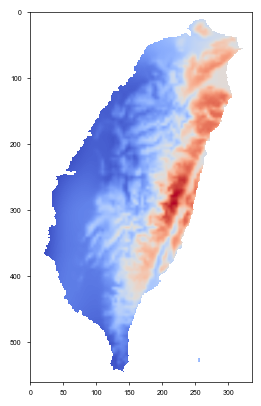

In [440]:
env_avg = None
for file in [env_inf['info']['clt'][date]['tif_span_avg'] for date in date_list_predict]:
    with rasterio.open(os.path.join(env_inf['dir_base'], file), 'r') as f:
        env_img = f.read(1)
        
    env_img = np.where(env_img == -9999, np.nan, env_img)
    if env_avg is not None:
        env_avg = env_avg + env_img
    else:
        env_avg = env_img
env_avg = env_avg / len(date_list_predict)
plt.imshow(env_avg, cmap = 'coolwarm')

0.12722433


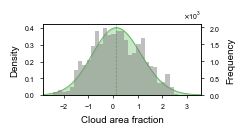

-0.38104334


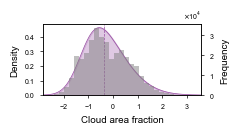

-0.13941677


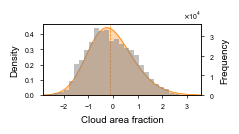

In [682]:
env_plot = 'clt'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()
    env_value_cluster = []

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        if len(i_threshold) >= 1000:
            sampled_indices = np.random.choice(i_threshold, size=1000, replace=False)
        else:
            needed_extra = 1000 - len(i_threshold)
            extra_indices = np.random.choice(i_threshold, size=needed_extra, replace=True)
            sampled_indices = np.concatenate([i_threshold, extra_indices])

        env_value = env_value[i_threshold]
        env_value_cluster.append(env_value)

    env_value_cluster = np.concatenate(env_value_cluster)

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value_cluster, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value_cluster)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value_cluster)
    print(median_val)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster-1], linewidth=0.5)

    jitter_strength = (env_max - env_min) * 0.005
    env_jittered = env_value_cluster + np.random.uniform(-jitter_strength, jitter_strength, size=env_value_cluster.shape)

#     sns.rugplot(env_jittered, ax=ax_pdf, height=0.05, linewidth=0.04, alpha=0.03, color=color_list[cluster-1])

    ax_pdf.set_xlabel('Cloud area fraction')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}{cluster}.pdf'), dpi=500, transparent=True)
    plt.show()


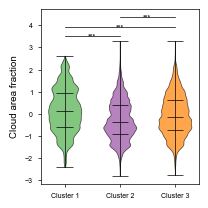

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=5386.1278603814635, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1467.5009046972455, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=9132.808621834502, pvalue=0.0)}


In [840]:
env_plot = 'clt'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

# Prepare storage for environmental values per cluster
cluster_env_values = {1: [], 2: [], 3: []}

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        env_value = env_value[i_threshold]
        cluster_env_values[cluster].extend(env_value)

# 執行 Kruskal-Wallis 檢定
pairwise_results = {
    'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
    'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
    'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
}

# 繪製 violin plot
fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                        showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

# 設定 violin plot 顏色
for i, body in enumerate(violin['bodies']):
    body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
    body.set_alpha(0.7)  # 調整透明度
    body.set_edgecolor('black')
    body.set_linewidth(0.5)
for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
    c_element.set_linewidth(0.5)
    c_element.set_color('black')



# 設定標籤
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_ylabel('Cloud area fraction')

# 計算標註位置
y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
y_step = (y_max - y_min) * 0.07  # 每條線間的間距

# 兩兩組合的比較位置
positions = [(1, 2), (1, 3), (2, 3)]
y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

# 加入顯著性標註與橫線
for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
    p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
    significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

    x1, x2 = pos1, pos2
    ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
    ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

# 儲存圖表
plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
# 顯示圖表
plt.show()

# 返回檢定結果
print(pairwise_results)

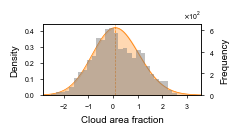

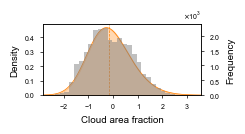

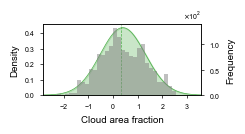

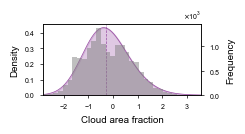

In [649]:
env_plot = 'clt'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for species in species_to_print:
    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

    occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
    env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

    mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
    occ_value = occ_value[mask]
    env_value = env_value[mask]

    i_threshold = np.where(occ_value == 1)[0]
    env_value = env_value[i_threshold]

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster_label[species_list_predict.index(species)]-1], linewidth=0.5)

    ax_pdf.set_xlabel('Cloud area fraction')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_{species}.pdf'), dpi=500, transparent=True)
    plt.show()


### landcoverPC1

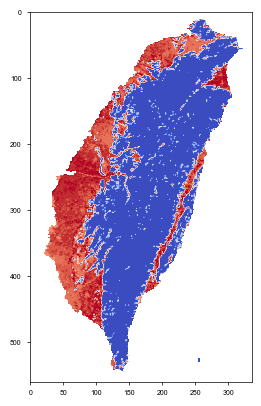

In [444]:
env_avg = None
for file in [env_inf['info']['landcover_PC00'][date]['tif_span_avg'] for date in date_list_predict]:
    with rasterio.open(os.path.join(env_inf['dir_base'], file), 'r') as f:
        env_img = f.read(1)
        
    env_img = np.where(env_img == -9999, np.nan, env_img)
    if env_avg is not None:
        env_avg = env_avg + env_img
    else:
        env_avg = env_img
env_avg = env_avg / len(date_list_predict)
plt.imshow(env_avg, cmap = 'coolwarm')

### 所有物種

-0.39305097


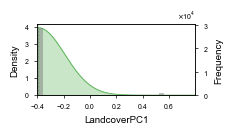

0.6619131


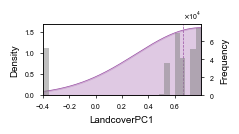

-0.39305097


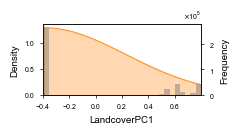

In [683]:
env_plot = 'landcover_PC00'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()
    env_value_cluster = []

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        if len(i_threshold) >= 1000:
            sampled_indices = np.random.choice(i_threshold, size=1000, replace=False)
        else:
            needed_extra = 1000 - len(i_threshold)
            extra_indices = np.random.choice(i_threshold, size=needed_extra, replace=True)
            sampled_indices = np.concatenate([i_threshold, extra_indices])

        env_value = env_value[i_threshold]
        env_value_cluster.append(env_value)

    env_value_cluster = np.concatenate(env_value_cluster)

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value_cluster, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value_cluster)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value_cluster)
    print(median_val)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster-1], linewidth=0.5)

    jitter_strength = (env_max - env_min) * 0.005
    env_jittered = env_value_cluster + np.random.uniform(-jitter_strength, jitter_strength, size=env_value_cluster.shape)

#     sns.rugplot(env_jittered, ax=ax_pdf, height=0.05, linewidth=0.04, alpha=0.03, color=color_list[cluster-1])

    ax_pdf.set_xlabel('LandcoverPC1')

    ax_pdf.set_xlim(env_min-0.01, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}{cluster}.pdf'), dpi=500, transparent=True)
    plt.show()


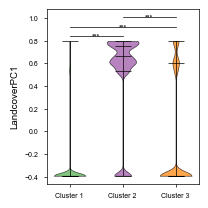

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=57696.40325347088, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=11283.040652407186, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=158096.77800426504, pvalue=0.0)}


In [841]:
env_plot = 'landcover_PC00'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

# Prepare storage for environmental values per cluster
cluster_env_values = {1: [], 2: [], 3: []}

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        env_value = env_value[i_threshold]
        cluster_env_values[cluster].extend(env_value)

# 執行 Kruskal-Wallis 檢定
pairwise_results = {
    'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
    'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
    'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
}

# 繪製 violin plot
fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                        showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

# 設定 violin plot 顏色
for i, body in enumerate(violin['bodies']):
    body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
    body.set_alpha(0.7)  # 調整透明度
    body.set_edgecolor('black')
    body.set_linewidth(0.5)
for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
    c_element.set_linewidth(0.5)
    c_element.set_color('black')



# 設定標籤
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_ylabel('LandcoverPC1')

# 計算標註位置
y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
y_step = (y_max - y_min) * 0.07  # 每條線間的間距

# 兩兩組合的比較位置
positions = [(1, 2), (1, 3), (2, 3)]
y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

# 加入顯著性標註與橫線
for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
    p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
    significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

    x1, x2 = pos1, pos2
    ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
    ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

# 儲存圖表
plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
# 顯示圖表
plt.show()

# 返回檢定結果
print(pairwise_results)

### 個別物種

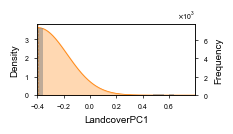

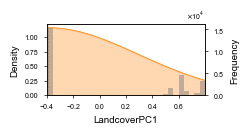

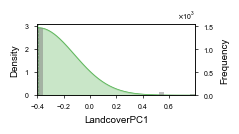

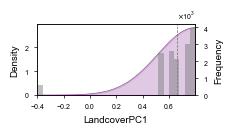

In [652]:
env_plot = 'landcover_PC00'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for species in species_to_print:
    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

    occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
    env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

    mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
    occ_value = occ_value[mask]
    env_value = env_value[mask]

    i_threshold = np.where(occ_value == 1)[0]
    env_value = env_value[i_threshold]

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster_label[species_list_predict.index(species)]-1], linewidth=0.5)

    ax_pdf.set_xlabel('LandcoverPC1')

    ax_pdf.set_xlim(env_min-0.01, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_{species}.pdf'), dpi=500, transparent=True)
    plt.show()


### hurs

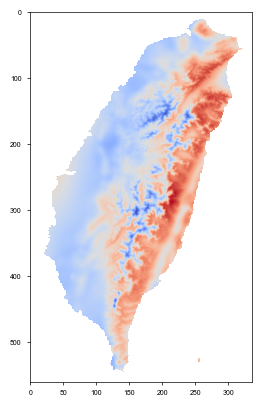

In [448]:
env_avg = None
for file in [env_inf['info']['hurs'][date]['tif_span_avg'] for date in date_list_predict]:
    with rasterio.open(os.path.join(env_inf['dir_base'], file), 'r') as f:
        env_img = f.read(1)
        
    env_img = np.where(env_img == -9999, np.nan, env_img)
    if env_avg is not None:
        env_avg = env_avg + env_img
    else:
        env_avg = env_img
env_avg = env_avg / len(date_list_predict)
plt.imshow(env_avg, cmap = 'coolwarm')

-0.62417644


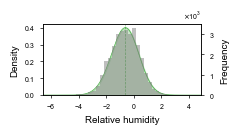

-0.49514565


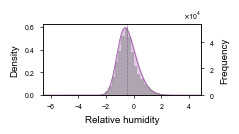

-0.22866534


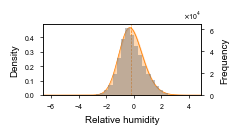

In [684]:
env_plot = 'hurs'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()
    env_value_cluster = []

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        if len(i_threshold) >= 1000:
            sampled_indices = np.random.choice(i_threshold, size=1000, replace=False)
        else:
            needed_extra = 1000 - len(i_threshold)
            extra_indices = np.random.choice(i_threshold, size=needed_extra, replace=True)
            sampled_indices = np.concatenate([i_threshold, extra_indices])

        env_value = env_value[i_threshold]
        env_value_cluster.append(env_value)

    env_value_cluster = np.concatenate(env_value_cluster)

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value_cluster, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value_cluster)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value_cluster)
    print(median_val)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster-1], linewidth=0.5)

    jitter_strength = (env_max - env_min) * 0.005
    env_jittered = env_value_cluster + np.random.uniform(-jitter_strength, jitter_strength, size=env_value_cluster.shape)

#     sns.rugplot(env_jittered, ax=ax_pdf, height=0.05, linewidth=0.04, alpha=0.03, color=color_list[cluster-1])

    ax_pdf.set_xlabel('Relative humidity')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}{cluster}.pdf'), dpi=500, transparent=True)
    plt.show()


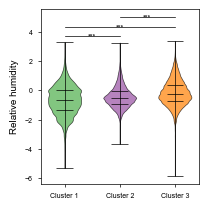

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=1166.2369510830388, pvalue=1.3275131890471264e-255), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=6251.49651775398, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=20353.221149592235, pvalue=0.0)}


In [842]:
env_plot = 'hurs'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

# Prepare storage for environmental values per cluster
cluster_env_values = {1: [], 2: [], 3: []}

for cluster in [1, 2, 3]:
    species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

    for species in species_list_cluster:
        df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

        occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
        env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

        mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
        occ_value = occ_value[mask]
        env_value = env_value[mask]

        i_threshold = np.where(occ_value == 1)[0]

        env_value = env_value[i_threshold]
        cluster_env_values[cluster].extend(env_value)

# 執行 Kruskal-Wallis 檢定
pairwise_results = {
    'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
    'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
    'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
}

# 繪製 violin plot
fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                        showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

# 設定 violin plot 顏色
for i, body in enumerate(violin['bodies']):
    body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
    body.set_alpha(0.7)  # 調整透明度
    body.set_edgecolor('black')
    body.set_linewidth(0.5)
for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
    c_element.set_linewidth(0.5)
    c_element.set_color('black')



# 設定標籤
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_ylabel('Relative humidity')

# 計算標註位置
y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
y_step = (y_max - y_min) * 0.07  # 每條線間的間距

# 兩兩組合的比較位置
positions = [(1, 2), (1, 3), (2, 3)]
y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

# 加入顯著性標註與橫線
for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
    p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
    significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

    x1, x2 = pos1, pos2
    ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
    ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

# 儲存圖表
plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
# 顯示圖表
plt.show()

# 返回檢定結果
print(pairwise_results)

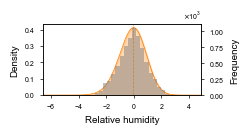

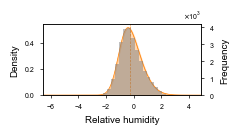

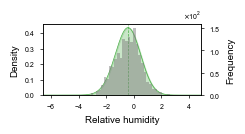

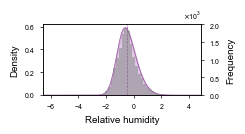

In [654]:
env_plot = 'hurs'
env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

for species in species_to_print:
    df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

    occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
    env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

    mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
    occ_value = occ_value[mask]
    env_value = env_value[mask]

    i_threshold = np.where(occ_value == 1)[0]
    env_value = env_value[i_threshold]

    fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                               gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

    ax_hist = ax_pdf.twinx()
    
    # Plot histogram on the right y-axis
    ax_hist.hist(env_value, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
    ax_hist.set_ylabel('Frequency')
    
    import matplotlib.ticker as mtick
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_hist.yaxis.set_major_formatter(formatter)
    
    
    # Skewed normal PDF on the left y-axis
    x_vals = np.linspace(env_min, env_max, 300)
    a, loc, scale = skewnorm.fit(env_value)
    skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

    ax_pdf.plot(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], lw=0.5)
    ax_pdf.fill_between(x_vals, skewed_pdf, color=color_list[cluster_label[species_list_predict.index(species)]-1], alpha=0.3)
    ax_pdf.set_ylabel('Density')

    median_val = np.median(env_value)
    ax_pdf.axvline(median_val, linestyle='--', color=color_list[cluster_label[species_list_predict.index(species)]-1], linewidth=0.5)

    ax_pdf.set_xlabel('Relative humidity')

    ax_pdf.set_xlim(env_min, env_max)
    ax_pdf.set_ylim(bottom=0)

    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_{species}.pdf'), dpi=500, transparent=True)
    plt.show()


In [ ]:
s

### 其他環境因子的violin plot

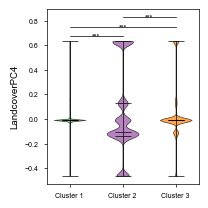

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=3379.095822119466, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=33.4830502370663, pvalue=7.1887748010620206e-09), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=20049.18535329355, pvalue=0.0)}


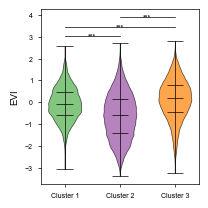

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=8652.677266201448, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1732.0701511022764, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=87442.43331923627, pvalue=0.0)}


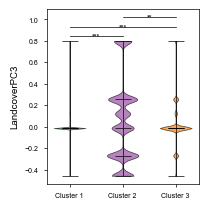

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=252.4041625265468, pvalue=7.768199938564097e-57), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=287.8945121537227, pvalue=1.4299759389494793e-64), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=9.923132463479384, pvalue=0.0016321436863424388)}


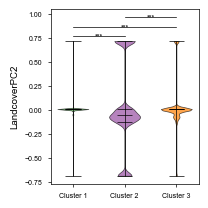

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=11526.39494303439, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1106.0778050572271, pvalue=1.577290968081921e-242), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=43177.32760800824, pvalue=0.0)}


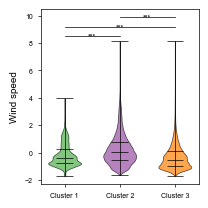

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=4081.242581977128, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1456.4252967905452, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=54659.72627381351, pvalue=0.0)}


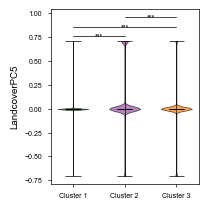

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=6736.10740808144, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1789.0985286176951, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=15611.483410041415, pvalue=0.0)}


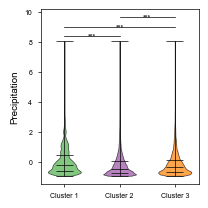

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=3477.7976206619905, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=1313.8514221497655, pvalue=1.1043981475048816e-287), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=4009.1583682637806, pvalue=0.0)}


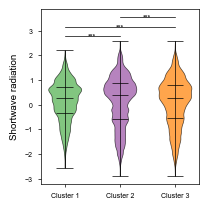

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=67.57186820375213, pvalue=2.031455219471633e-16), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=13.73938014726967, pvalue=0.00021000478821476688), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=764.5412075120629, pvalue=2.7647738113394004e-168)}


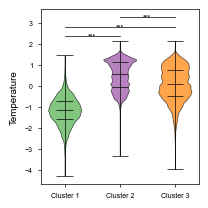

{'Cluster 1 vs Cluster 2': KruskalResult(statistic=70591.36487831724, pvalue=0.0), 'Cluster 1 vs Cluster 3': KruskalResult(statistic=50315.34919496231, pvalue=0.0), 'Cluster 2 vs Cluster 3': KruskalResult(statistic=46974.680438981566, pvalue=0.0)}


In [853]:
for env_plot in list(set(env_list) - set(['hurs', 'landcover_PC00', 'clt'])):
    env_min = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().min()
    env_max = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten().max()

    # Prepare storage for environmental values per cluster
    cluster_env_values = {1: [], 2: [], 3: []}

    for cluster in [1, 2, 3]:
        species_list_cluster = np.array(species_list_predict)[np.array(cluster_label) == cluster].tolist()

        for species in species_list_cluster:
            df_species = feather.read_dataframe(os.path.join(plot_path_df, f'{species}.feather'))

            occ_value = df_species[sorted([key for key in df_species.keys() if key.startswith('occ')])].values.flatten()
            env_value = df_env_value[sorted([key for key in df_env_value.keys() if key.startswith(env_plot)])].values.flatten()

            mask = ~np.isnan(occ_value) & ~np.isnan(env_value)
            occ_value = occ_value[mask]
            env_value = env_value[mask]

            i_threshold = np.where(occ_value == 1)[0]

            env_value = env_value[i_threshold]
            cluster_env_values[cluster].extend(env_value)

    # 執行 Kruskal-Wallis 檢定
    pairwise_results = {
        'Cluster 1 vs Cluster 2': kruskal(cluster_env_values[1], cluster_env_values[2]),
        'Cluster 1 vs Cluster 3': kruskal(cluster_env_values[1], cluster_env_values[3]),
        'Cluster 2 vs Cluster 3': kruskal(cluster_env_values[2], cluster_env_values[3]),
    }

    # 繪製 violin plot
    fig, ax = plt.subplots(figsize=mm2inch(50, 50), constrained_layout=True)
    violin = ax.violinplot([cluster_env_values[1], cluster_env_values[2], cluster_env_values[3]], 
                            showmeans=False, showmedians=True, showextrema=True, widths=0.6, quantiles = [[0.25, 0.75], [0.25, 0.75], [0.25, 0.75]])

    # 設定 violin plot 顏色
    for i, body in enumerate(violin['bodies']):
        body.set_facecolor(color_list[i])  # 設定每個 violin 的顏色
        body.set_alpha(0.7)  # 調整透明度
        body.set_edgecolor('black')
        body.set_linewidth(0.5)
    for c_element in [violin['cmaxes'], violin['cmins'], violin['cbars'], violin['cmedians'], violin['cquantiles']]:
        c_element.set_linewidth(0.5)
        c_element.set_color('black')



    # 設定標籤
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
    ax.set_ylabel(f'{env_list_change[env_plot]}')

    # 計算標註位置
    y_max = max([max(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最大 y 值
    y_min = min([min(cluster_env_values[i]) for i in [1, 2, 3]])  # 取得最小 y 值
    y_step = (y_max - y_min) * 0.07  # 每條線間的間距

    # 兩兩組合的比較位置
    positions = [(1, 2), (1, 3), (2, 3)]
    y_levels = [y_max + 0.5 * y_step, y_max + 1.5 * y_step, y_max + 2.5 * y_step]  # 每條線的 y 位置

    # 加入顯著性標註與橫線
    for i, ((pos1, pos2), y_pos) in enumerate(zip(positions, y_levels)):
        p_value = pairwise_results[list(pairwise_results.keys())[i]][1]  # 取得 p-value
        significance = get_significance_stars(p_value)  # 取得對應的顯著性標註

        x1, x2 = pos1, pos2
        ax.plot([x1, x2], [y_pos, y_pos], color='black', linewidth=0.5)  # 畫 "匚" 型橫線
        ax.text((x1 + x2) / 2, y_pos, significance, ha='center', va='center', fontsize=5)

    # 儲存圖表
    plt.savefig(os.path.join(plot_path_responsecurve, f'{env_plot}_violin.pdf'), dpi=500, transparent=True)
    # 顯示圖表
    plt.show()

    # 返回檢定結果
    print(pairwise_results)